# Various IBD related Plots

In [1]:
import socket as socket
import os as os
import sys as sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib import gridspec

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA//"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())

sys.path.append("/n/groups/reich/hringbauer/git/hapBLOCK/python3/") 
#from main import HMM_Full
from run import hapBLOCK_chrom, run_plot_pair
#from plot.plot_posterior import plot_posterior, plot_posterior_panel

### hapsburgImport
sys.path.append("/n/groups/reich/hringbauer/git/HAPSBURG/package/")
from hapsburg.PackagesSupport.parallel_runs.helper_functions import combine_individual_data

#sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/package/")  # hack to get development package first in path
#from hapBLOCK.IO.h5_load import get_opp_homos_f

compute-e-16-231.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA


Filtering to 0.99 GP variants: 0.878x
Filtering to 0.99 GP variants: 0.897x
Filtering to common GP variants: 0.814x
Plotting 89082 markers


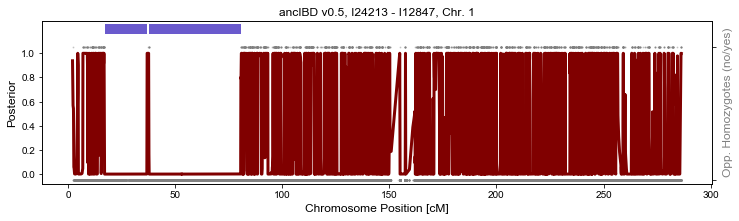

In [2]:
post = run_plot_pair(iids=["I24213", "I12847"], ch=1, 
                     path_h5='/n/groups/reich/hringbauer/git/hapBLOCK/data/hdf5/1240k_v49.2/ch',
                     min_cm=4, plot=True, l_model="hdf5",
                     p_col="variants/AF_ALL", folder_out="", output=False)	 

# Karyotype Plots

### Functions to load IBD Blocks

In [3]:
sys.path.append("/n/groups/reich/hringbauer/git/hapBLOCK/python3/")  # hack to get development package first in path
from ibd_stats.funcs import new_columns, give_sub_df
from hapsburg.PackagesSupport.pp_individual_roh_csvs import merge_called_blocks, post_process_roh_df

In [4]:
def load_roh(iid, ch, path_folder = "./Empirical/1240k/", prefix_out = "e01/"):
    """Load the ROH Dataframe for Individual iid and 
    Chromosome ch"""
    path = path_folder +  iid + "/chr" + str(ch) + "/" + prefix_out+ "/roh.csv"
    roh_df = pd.read_csv(path)    
    return roh_df

def post_process_roh_df1(df, min_cm=4, snp_cm=100, output=False):
    """Post Process ROH Dataframe.
    min_cm: Minimum Length in CentiMorgan
    snp_cm: How many SNPs per CentiMorgan"""
    densities = df["length"] / (df["lengthM"] * 100)
    densities_ok = (densities > snp_cm)
    
    df["SNP_Dens"] = densities
    
    # Filter for SNP Density:
    df = df[densities_ok]
    
    # Filter for Length:
    length_okay = (df["lengthM"] * 100) > min_cm
    
    if output==True:
        print(f"Min SNPs per cM> {snp_cm}: {np.sum(densities_ok)}/{len(densities_ok)}")
        print(f"> {min_cm} cM: {np.sum(length_okay)}/{len(length_okay)}")
    
    df = df[length_okay]
    return df


def chrom_length(ch, ch_lengths=[], output=False):
    """Get and return length of Chromosome ch
    If ch_lengths not given, use default (from Eigenstrat map).
    Atm only do autosomes!"""
    if len(ch_lengths)==0:
        ch_lengths = [2.86273, 2.688325, 2.232573, 2.145423,
                      2.040858, 1.920325, 1.871526, 1.680022,
                      1.66301, 1.809153, 1.582171, 1.746799,
                      1.257046, 1.202023, 1.41346, 1.340263,
                      1.284738, 1.177099, 1.077316, 1.082134,
                      0.627865, 0.740762]
        return ch_lengths[ch-1]

def load_individual_roh(iid, min_cm=4, gap=0.0, snp_cm=50, path_folder = "./Empirical/1240k/", 
                        prefix_out = "", folder="./Empirical/1240k/", output=False):
    """Load ROH of one Individual"""
    df_rohs = []
    for i in range(1,23):
        df_roh = load_roh(iid=iid, ch=i, path_folder = folder, prefix_out = prefix_out)
        df_roh = merge_called_blocks(df_roh, max_gap=gap/100, output=output) # Merge Blocks
        df_roh = post_process_roh_df(df_roh, min_cm=min_cm, snp_cm=snp_cm, output=output) # Only use Blocks with high enough SNP density
        df_rohs.append(df_roh)
    return df_rohs

def load_bad_areas(path="./Data/1000Genomes/Markers/1240k/snp_density.csv", min_snps=50):
    """Load areas of low SNP density, and return list of Dataframes 
    (one for each chromosome)"""
    df_lows = []
    
    for i in range(1,23):
        df_t = pd.read_csv(path, sep="\t")
        df_t = df_t[df_t["chr"]==i]
        df_t = df_t[df_t["counts"]<min_snps]
        df_lows.append(df_t)
    return df_lows

def plot_chromosome(ax, l, x_pos, lw=24, df_roh = [], df_low = []):
    """Plot a Chromosome of length l with centromer ctr on ax 
    at x_pos"""
    ln, = ax.plot([x_pos, x_pos], [-0.05,l+0.05], lw = lw, color="lightgray",
                      solid_capstyle = 'round', zorder=0,
                  path_effects=[pe.Stroke(linewidth=lw+3, foreground='k'), pe.Normal()])
    
    ### Plot the ROH List if given
    if len(df_roh) > 0:
        starts, ends = df_roh["StartM"].values, df_roh["EndM"].values
        
        for i in range(len(df_roh)):
            ax.plot([x_pos, x_pos], [starts[i], ends[i]], lw=lw, color="maroon", 
                    zorder=1, alpha=1.0, solid_capstyle="butt")
    
    ### Plot shadows of bad areas
    if len(df_low)>0:
        starts, ends = df_low["StartM"].values, df_low["EndM"].values
        
        for i in range(len(df_low)):
            ax.plot([x_pos, x_pos], [starts[i], ends[i]], lw=lw, color="k", 
                    zorder=2, alpha=0.8, solid_capstyle="butt")
        
            
def plot_roh_individual(df_ibd, fs=12, figsize=(8,8), savepath="", 
                        plot_bad=True, title="", plot=True):
    """Plot ROH in one ancient Individual.
    gap: What Gap to Merge [in cM!]
    prefix_out: If there is a folder before indivual data, e.g. e01/"""
    
    ### Load the Data (could be done seperately)
    df_lows=[[] for _ in range(23)] ### Plot the excluded areas. Placeholder
    
    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 2])
    gs.update(hspace=0.1) # set the spacing between axes. 

    ax = plt.subplot(gs[0]) # The left subplot
    ax1 = plt.subplot(gs[1]) # The middle one
        
    ### Plot the First 11 Chromosomes
    for i in range(1,12):
        l = chrom_length(i)
        plot_chromosome(ax, l, x_pos=(i), df_roh=df_ibd[i-1], df_low=[])  
    
    ### Plot the Second 11 Chromosomes
    for i in range(12,23):
        l = chrom_length(i)
        plot_chromosome(ax1, l, x_pos=(i - 11), df_roh=df_ibd[i-1], df_low=[])

    ### Set the Plot Limits
    ax.set_xlim([0.3, 11.5])
    ax1.set_xlim([0.3, 11.5])

    ax.set_ylim([-0.3,3.3])
    ax1.set_ylim([-0.3, 2.05])

    ### Turn off the Y Axis
    for ax0 in [ax, ax1]:
        ax0.spines['right'].set_visible(False)
        ax0.spines['top'].set_visible(False)
        ax0.spines['bottom'].set_visible(False)
        ax0.yaxis.set_tick_params(labelsize=fs)

    rang = np.arange(1,12)
    ax.set_xticks(rang)
    ax.set_xticklabels(rang, fontsize=fs)

    ax1.set_xticks(rang)
    ax1.set_xticklabels(rang+11, fontsize=fs)
    ax1.set_xticklabels(rang+11, fontsize=fs)
    
    if len(title)>0:
        ax.set_title(title, fontsize=fs*2)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Saved figure to {savepath}")
    if plot:
        plt.show()
    
    
##########################################################
### Plot Length Distributions

def expected_block_pdf(x, chr_l, m):
    """Gives back the pdfs for Blocks of Length l [Morgan]
    on a Chromosome of Length [Morgan].
    m: Nr of Meiosis.
    Return PDF (per Morgan)"""
    pdf0 = (chr_l - x) * m**2 * np.exp(-x * m)
    pdf1 = 2 * np.exp(- x * m) * m 
    return (pdf0 + pdf1) * (x < chr_l)  # If x < chr_l return 0

def expected_block_pdf_chromosomes(x, chr_lgts, m):
    """Calculate the PDF of ROH blocks of length x [Morgan]
    for m Recombination events
    x: Can be Array
    chr_lgts: Array of all chromosome lengths [in Morgan]
    Return PDF (per Morgan)"""
    pdfs = [expected_block_pdf(x, chr_l, m) for chr_l in chr_lgts]
    pdf_full = np.sum(pdfs, axis=0)
    return pdf_full

def coal_prob(m, comm_anc=1):
    """Calculate Coalescence Probability.
    m: Nr of Meiosis
    comm_anc: How many common ancestors"""
    c_prob = comm_anc * (1 / 2) ** m
    return c_prob

def exp_blocks_full_individual(x, m, comm_anc=1):
    """Calculates the Expected Nr of ROH Blocks per Morgan for full Individual
    x: Array of Block Lenths
    m: Nr of Meisois
    comm_anc: Nr of Ancestry Loops"""
    
    chr_lgts = [chrom_length(ch) for ch in range(1,23)]
    
    pdf_full = expected_block_pdf_chromosomes(x, chr_lgts, m)
    c_prob = coal_prob(m, comm_anc)
    exp_blocks = pdf_full * c_prob
    return exp_blocks


def plot_pde_individual(df_ibd, figsize=(8,6), bw_cm=4,
                        plotlim=[4,100], savepath="", 
                        output=False, lw_curve=3,
                        comm_ancs=[4,4,4,2], ms=[6,5,4,3], labels=["First Cousins", "Aunt/Nephew", "Full Siblings", "Parent/Offpsring"],
                        cs=["red", "green", "orange", "gray"], title="", leg_loc="upper right"):
    """Plot Histograms/PDEs of ROH Distribution for one Individual (iid)
    bw_cm: Length of one Bin (in cM)
    comm_ancs: How many common ancestors to plot [list]
    ms: How many meiosis to plot [list]
    labels: what labels do they have [list]
    cs: what colors to plot [list]"""

    ### Load And Prepare Data
    bins = np.arange(plotlim[0], plotlim[1], bw_cm)
    bin_mean = (bins[1:] + bins[:-1]) / 2.0  # Mean of each bin
    
    ### Do the Plot
    fs = 16

    plt.figure(figsize=figsize)
    ax=plt.gca()
    ax.hist(df_ibd["lengthM"]*100, bins=bins, ec="k", fc="dodgerblue", label="Observed IBD")
    
    # Plot the Empirical Averages
    for i in range(len(labels)):
        block_pdf = exp_blocks_full_individual(bin_mean/100, m=ms[i], comm_anc=comm_ancs[i])
        ax.plot(bin_mean, bw_cm * block_pdf/100, c=cs[i], label=labels[i], lw=lw_curve) # Plot Density Per cM (adjusted for bin width)

    plt.xlabel("IBD Length [cm]", fontsize=fs)
    plt.ylabel(f"Number per {bw_cm} cM Bin", fontsize=fs)
    plt.title(title, fontsize=fs)
    leg = plt.legend(loc = leg_loc, fontsize=fs)
    leg.set_title("Relationship:", prop = {'size':fs})
    
    plt.tick_params(axis='both', which='major', labelsize=fs)
    
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0, dpi=300)
        print(f"Saved to {savepath}.")
    plt.show()

### Load called IBD Data

In [5]:
#path_ibd = "/n/groups/reich/hringbauer/git/boehmen/output/ibd/v43.3/ch_all.tsv"
#path_ibd = "/n/groups/reich/hringbauer/git/ibd_euro/output/ibd/ibd220.ibd.v46.3.tsv"
path_ibd = "/n/groups/reich/hringbauer/git/ibd_euro/output/ibd/ibd220.ibd.v49.2.tsv"
#path_ibd = "/n/groups/reich/hringbauer/git/yamnaya/output/ibd/target/RISE550.SGch_all.tsv"
df_ibd = pd.read_csv(path_ibd, sep="\t")

In [6]:
iid1, iid2 = "I24213", "I12847"

#iid1, iid2 = "I20078", "SA6004"
df_target = give_sub_df(df_ibd, pop1=iid1, pop2=iid2, col="iid")
df_target = df_target[df_target["lengthM"]>0.12]
df_ibds = [df_target[df_target["ch"]==i] for i in range(1,23)]

Found: 3 Pairs fitting in dataframe.



Saved figure to ./figures//ibd/karyotype/I24213_I12847_karyotype.png


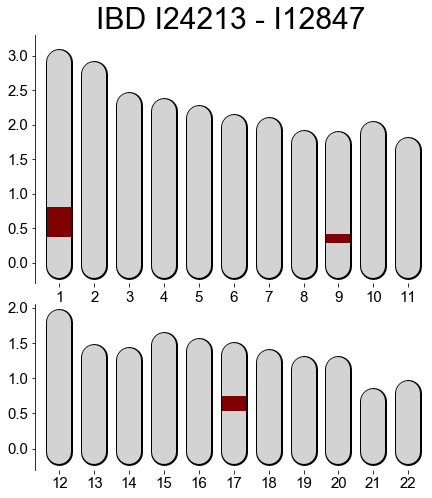

In [14]:
plot_roh_individual(df_ibds, savepath=f"./figures//ibd/karyotype/{iid1}_{iid2}_karyotype.png", 
                    fs=15, title='IBD I24213 - I12847', figsize=(7, 8)) 

# Area 51
Try out code here

In [6]:
df_target = give_sub_df(df_ibd, pop1=iid1, pop2=iid2, col="iid")

Found: 3 Pairs of Individuals with IBD stats.

